# Project Milestone Two

**Data Preparation and Model Exploration**
**Due:** Midnight on November 16th with usual 2-hour grace period — **worth 100 points**

**Note: No late assignments accepted, we need the time to grade them!**

In Milestone 1, your team selected a dataset (Food-101 or HuffPost), analyzed its structure, and identified key challenges and evaluation metrics.
In this milestone, you will carry out those plans: prepare the data, train three models of increasing sophistication, and evaluate their results using Keras and TensorFlow.
You will finish with a comparative discussion of model performance and trade-offs.


### Submission Guidelines

* Submit one Jupyter notebook per team through the team leader’s Gradescope account. **Include all team members names at the top of the notebook.** 
* Include all code, plots, and answers inline below.
* Ensure reproducibility by setting random seeds and listing all hyperparameters.
* Document any AI tools used, as required by the CDS policy.


In [7]:
# ============================================
# Useful Imports
# ============================================

# --- Standard Libraries
import os
import time
import math
import random
from collections import Counter

# --- Core Data / Numerics
import numpy as np
import pandas as pd

# --- Visualization
import matplotlib.pyplot as plt
# import seaborn as sns              # optional
import matplotlib.ticker as mticker  # optional (for formatted axes)

# --- NLP / Tokenization
import spacy                         # used for text preprocessing (HuffPost)

# --- Progress Tracking
from tqdm import tqdm                # optional (nice for loops)

from IPython.display import display

# --- TensorFlow / Keras (Deep Learning)
import tensorflow as tf
from tensorflow.keras import layers, models, Input, callbacks, regularizers, initializers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, MaxPooling2D, Conv2D,
    SeparableConv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
)

# hugging face
# --- Hugging Face Datasets
from datasets import load_dataset, DatasetDict
from datasets.features import ClassLabel

# --- (Optional) Classical ML Baseline Tools
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score


# ============================================
# Global Configuration & Small Utilities
# ============================================

# Reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)   # sets Python, NumPy, and TensorFlow seeds

# Utility: format seconds as HH:MM:SS

"""
Example usage to time your code:

start_time = time.time()
# ... your code here ...
print("Execution Time:", format_hms(time.time() - start_time))
"""

def format_hms(seconds: float) -> str:
    """Convert seconds to HH:MM:SS format."""
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

# load dataset
from datasets import load_from_disk
print("loading huffpost dataset")
huff_all = load_from_disk("huffpost_splits")  # reload when needed

loading huffpost dataset


## Problem 1 – Data Preparation and Splits (20 pts)

### Goals

Implement the **data preparation and preprocessing steps** that you proposed in **Milestone 1**. You’ll clean, normalize, and split your data so that it’s ready for modeling and reproducible fine-tuning.

### Steps to Follow

1. **Load your chosen dataset**

   * Use `datasets.load_dataset()` from **Hugging Face** to load **Food-101** or **HuffPost**.
   * Display basic information (e.g., number of samples, feature names, example entries).

2. **Apply cleaning and normalization**

   * **Images:**

     * Ensure all images are in RGB format.
     * Resize or crop to a consistent shape (e.g., `224 × 224`).
     * Drop or fix any corrupted files.
   * **Text:**

     * Concatenate headline + summary (for HuffPost).
     * Strip whitespace, convert to lowercase if appropriate, and remove empty samples.
     * Optionally remove duplicates or extremely short entries.

3. **Standardize or tokenize the inputs**

   * **Images:**

     * Normalize pixel values (e.g., divide by 255.0).
     * Define a minimal augmentation pipeline (e.g., random flip, crop, or rotation).
   * **Text:**

     * Create a tokenizer or `TextVectorization` layer.
     * Set a target `max_length` based on your analysis from Milestone 1 (e.g., 95th percentile).
     * Apply padding/truncation and build tensors for input + labels.

4. **Handle dataset-specific challenges**

   * If you identified **class imbalance**, compute label counts and, if needed, create a dictionary of `class_weights`.
   * If you noted **length or size variance**, verify that your truncation or resizing works as intended.
   * If you planned **noise filtering**, include the cleaning step and briefly explain your criteria (e.g., remove items with missing text or unreadable images).

5. **Create reproducible splits**

   * Split your cleaned dataset into **train**, **validation**, and **test** subsets (e.g., 80 / 10 / 10).
   * Use a fixed random seed for reproducibility (`random_seed = 42`).
   * Use **stratified splits**  (e.g., with `train_test_split` and `stratify = labels`).
   * Display the size of each subset.

6. **Document your pipeline**

   * Summarize your preprocessing steps clearly in Markdown or code comments.
   * Save or display a few representative examples after preprocessing to confirm the transformations are correct.


## Import dataset and run Emma data cleaning/tokenization scripts

In [8]:
# Your code here; add as many cells as you need but make it clear what the structure is. 
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

# combine headline & short_description into 1 text field
def combine_fields(prob2):
  headline = prob2.get('headline', '') or ""
  short_desc = prob2.get('short_description', '[NO_DESC]') or "[NO_DESC]"
  prob2['text'] = f"{headline} [SEP] {short_desc}"
  return prob2

huff_all = huff_all.map(combine_fields)
print(huff_all.column_names)
print(huff_all[0])

# write to pandas
df_prob2 = huff_all.to_pandas()

# Solution 1: Merge Duplicate/Overlapping Categories
merge_map = {
    'WORLDPOST': 'WORLD NEWS',
    'ARTS': 'ARTS & CULTURE',
    'ARTS & CULTURE': 'CULTURE & ARTS',
    'STYLE': 'STYLE & BEAUTY',
    'PARENTS': 'PARENTING'
    }
df_prob2['category'] = df_prob2['category'].replace(merge_map)

# Solution 2: Handle Missing short_description
df_prob2['short_description'] = df_prob2['short_description'].replace('','[NO_DESC]').fillna('[NO_DESC]')

# Solution 3: Combine headline and short_description into a single field to avoid short text length
df_prob2['headline'] = df_prob2['headline'].fillna('')
df_prob2['text'] = df_prob2['headline'] + " [SEP] " + df_prob2['short_description']

# Solution 4: Deduplicating
df_prob2 = df_prob2.drop_duplicates(subset=["text"]).reset_index(drop=True)

# Solution 5: Stratified Split with train/val/test/split
train_df, temp_df = train_test_split(
    df_prob2,
    test_size=0.30,
    stratify=df_prob2['category'],
    random_state=42
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,  # Split temp equally into val/test (15% each of total)
    stratify=temp_df['category'],
    random_state=42
)

# convert splits back to Hugging Face Datasets
train_ds = Dataset.from_pandas(train_df[['text', 'category']], preserve_index=False)
val_ds   = Dataset.from_pandas(val_df[['text', 'category']], preserve_index=False)
test_ds  = Dataset.from_pandas(test_df[['text', 'category']], preserve_index=False)


# Solution 6: Compute/Apply Class Weights to handle Imbalance
categories = np.unique(df_prob2['category'])
weights = compute_class_weight(
    class_weight='balanced',
    classes=categories,
    y=df_prob2['category']
)

print('\nClass weights examples:')
print(dict(zip(categories[:5], weights[:5])))

# Solution 7: Tokenization with DistilBERT & max_length=128
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(batch):
  return tokenizer(
      batch['text'],
      padding='max_length',
      truncation=True,
      max_length=128, 
      return_tensors='tf'
  )
train_ds = train_ds.map(tokenize_fn, batched=True)
val_ds   = val_ds.map(tokenize_fn, batched=True)
test_ds  = test_ds.map(tokenize_fn, batched=True)


# Solution 8: Label Encode category column into integers
le = LabelEncoder()
all_labels = list(train_ds['category']) + list(val_ds['category']) + list(test_ds['category'])
le.fit(all_labels)
num_labels = len(le.classes_)

def encode_labels(batch):
    batch['labels'] = le.transform([batch['category']])[0]
    return batch

train_ds = train_ds.map(encode_labels)
val_ds   = val_ds.map(encode_labels)
test_ds  = test_ds.map(encode_labels)

['category', 'headline', 'authors', 'link', 'short_description', 'date', 'text']
{'category': 'CRIME', 'headline': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV', 'authors': 'Melissa Jeltsen', 'link': 'https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89', 'short_description': 'She left her husband. He killed their children. Just another day in America.', 'date': datetime.datetime(2018, 5, 26, 0, 0), 'text': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV [SEP] She left her husband. He killed their children. Just another day in America.'}

Class weights examples:
{'ARTS & CULTURE': 3.588648290437555, 'BLACK VOICES': 1.1972739929848044, 'BUSINESS': 0.9127372779825165, 'COLLEGE': 4.733627858627859, 'COMEDY': 1.048658069378441}


Map: 100%|██████████| 30055/30055 [00:01<00:00, 19630.86 examples/s]


## Utilities - load and save datasets

In [9]:
# save datasets to disk for future reload
from datasets import DatasetDict
import pickle

# Create a DatasetDict
processed_datasets = DatasetDict({
    'train': train_ds,
    'validation': val_ds,
    'test': test_ds
})

# save to disk
processed_datasets.save_to_disk("huffpost_processed_milestone2")

# save the label encoder
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)
print("Label encoder saved to label_encoder.pkl")

# save class weights as well
class_weights = weights 
np.save('class_weights.npy', class_weights)
print("Class weights saved to class_weights.npy")


# For quick reload! 
#import pickle

#processed_datasets = load_from_disk("huffpost_processed_milestone2")
#train_ds = processed_datasets['train']
#val_ds = processed_datasets['validation']
#test_ds = processed_datasets['test']

#with open('label_encoder.pkl', 'rb') as f:
#    le = pickle.load(f)

# Load weights
#class_weights = np.load('class_weights.npy')

# Use as TF tensor when needed
#class_weights_tf = tf.constant(class_weights, dtype=tf.float32)
#num_labels = len(le.classes_)

#print(f"Loaded: Train={len(train_ds)}, Val={len(val_ds)}, Test={len(test_ds)}")

Saving the dataset (1/1 shards): 100%|██████████| 30055/30055 [00:00<00:00, 2013445.46 examples/s]

Label encoder saved to label_encoder.pkl
Class weights saved to class_weights.npy


In [10]:
# For quick reload! 
import pickle
from datasets import load_from_disk

processed_datasets = load_from_disk("huffpost_processed_milestone2")
train_ds = processed_datasets['train']
val_ds = processed_datasets['validation']
test_ds = processed_datasets['test']

with open('label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

# Load weights
class_weights = np.load('class_weights.npy')

# Use as TF tensor when needed
class_weights_tf = tf.constant(class_weights, dtype=tf.float32)
num_labels = len(le.classes_)

print(f"Loaded: Train={len(train_ds)}, Val={len(val_ds)}, Test={len(test_ds)}")

Loaded: Train=140255, Val=30055, Test=30055


In [11]:
train_ds

Dataset({
    features: ['text', 'category', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 140255
})

### Graded Questions (5 pts each)

For each question, answer thoroughly but concisely, in a short paragraph, longer or shorter as needed. Code for exploring the concepts should go in the previous cell
as much as possible. 

1. **Data Loading and Cleaning:**
   Describe how you loaded your dataset and the key cleaning steps you implemented (e.g., handling missing data, normalizing formats, or removing duplicates).

1.1. **Your answer here:**

        The raw dataset was loaded directly from Hugging Face and each record includes a headline, a short decription, a category, authors, and the date of publication. The headline and short_descriptions were merged and extra whitespaced removed. The categories were then normalized and overlapping categories were combined. Any missing data was replaced with empy strings to allow to tokenization later. Duplicates were dropped who had the same headline and short_description.


2. **Preprocessing and Standardization:**
   Summarize your preprocessing pipeline. Include any normalization, tokenization, resizing, or augmentation steps, and explain why each was necessary for your dataset.
  

1.2. **Your answer here:**

        Normalization steps included the removal of any excessive whitesapce using regex, missing text was filled with an empty string or [NO_DESC] to allow for later tokenization, and duplicate entries with the same headline and short_description were dropped. DistilBERT was selected as our tokenizer and included padding of the 'max_length' set to 128 and truncation. This tokenization is important since it makes sure all sequences have the same length and are mapped to their corresponding input_ids. Additionally, we used label encoding to convert all categories into IDs and class weight normalization to handle category imbalance present in the dataset to prevent bias towards dominant new topics and improve model generalization.

3. **Train/Validation/Test Splits:**
   Explain how you divided your data into subsets, including the split ratios, random seed, and any stratification or leakage checks you used to verify correctness.


1.3. **Your answer here:**

        After cleaning and normalization, the dataset was divided into training, validation, and test sets and splits were stratifid by category. The data was split into a 70/15/15 split which we deemed would likely preserve plenty of samples in both the validation and test sets to create a robust model. Stratification was used during the train_test_split to maintain balance in the categories. It is important to note that splitting was done after data cleaning and normalization to prevent duplicate information and data leakage.


4. **Class Distribution and Balance:**
   Report your label counts and describe any class imbalances you observed. If applicable, explain how you addressed them (e.g., weighting, oversampling, or data augmentation).


1.4. **Your answer here:**

        The outputs from the split after data normalization, cleaning, and tokenization indicate that the proportions were consistent for each category and roughly equal across all subsets. This indicates that our stratification worked as intended and there is minimal data leakage or bias detected. For example, the POLITICS category after splitting has a train frequency of 16.3% which is identical to the validation and test frequencies which are also at 16.3%.

## Problem 2 – Baseline Model (20 pts) (Plus get the helper functions all imported into the notebook week 7) (Emma)

### Goal
Build and train a **simple, fully functional baseline model** to establish a reference level of performance for your dataset.
This baseline will help you evaluate whether later architectures and fine-tuning steps actually improve results.

### Steps to Follow

1. **Construct a baseline model**

   * **Images:**
     Use a compact CNN, for example
     `Conv2D → MaxPooling → Flatten → Dense → Softmax`.
   * **Text:**
     Use a small embedding-based classifier such as
     `Embedding → GlobalAveragePooling → Dense → Softmax`.
   * Keep the model small enough to train in minutes on Colab.

2. **Compile the model**

   * Optimizer: `Adam` or `AdamW`.
   * Loss: `categorical_crossentropy` (for multi-class).
   * Metrics: at least `accuracy`; add `F1` if appropriate.

3. **Train and validate**

   * Use **early stopping** on validation loss with the default patience value (e.g., 5 epochs).
   * Record number of epochs trained and total runtime.

4. **Visualize results**

   * Plot **training vs. validation accuracy and loss**.
   * Carefully observe: does the model underfit, overfit, or generalize reasonably?

5. **Report baseline performance**

   * The most important metric is the **validation accuracy at the epoch of minimum validation loss**; this serves as your **benchmark** for all later experiments in this milestone.
   * Evaluate on the **test set** and record final metrics.

In [12]:
# Your code here; add as many cells as you need but make it clear what the structure is. 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

X_train = train_df['text'].values
X_val = val_df['text'].values
X_test = test_df['text'].values

y_train = train_df['category'].values
y_val = val_df['category'].values
y_test = test_df['category'].values

lb = LabelBinarizer()
y_train_enc = lb.fit_transform(y_train)
y_val_enc   = lb.transform(y_val)
y_test_enc  = lb.transform(y_test)

num_classes = len(lb.classes_)
print("number of classes:", num_classes)

# Vectorization

max_vocab = 20000
max_len = 128
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=max_vocab,
    output_sequence_length=max_len,
    standardize='lower_and_strip_punctuation'
)
vectorizer.adapt(X_train)

# Baseline MOdel

embedding_dim = 128

inputs = tf.keras.Input(shape=(1,), dtype=tf.string)
x = vectorizer(inputs)
x = tf.keras.layers.Embedding(input_dim=max_vocab, output_dim=embedding_dim)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

baseline_model = tf.keras.Model(inputs, outputs)
baseline_model.summary()

# Put model together
baseline_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

start_time = time.time()
history = baseline_model.fit(
    X_train, y_train_enc,
    validation_data=(X_val, y_val_enc),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

print(f"Training completed in {round(time.time() - start_time, 2)} seconds.")

number of classes: 37


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 128)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 128, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 37)             │         4,773 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,581,285 (9.85 MB)

 Trainable params: 2,581,285 (9.85 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2025-11-06 19:55:56.099935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


4383/4383 ━━━━━━━━━━━━━━━━━━━━ 80s 18ms/step - accuracy: 0.3505 - loss: 2.5042 - val_accuracy: 0.4941 - val_loss: 1.9202
Epoch 2/20
4383/4383 ━━━━━━━━━━━━━━━━━━━━ 79s 18ms/step - accuracy: 0.5307 - loss: 1.7720 - val_accuracy: 0.5691 - val_loss: 1.6299
Epoch 3/20
4383/4383 ━━━━━━━━━━━━━━━━━━━━ 87s 20ms/step - accuracy: 0.5904 - loss: 1.5302 - val_accuracy: 0.5760 - val_loss: 1.5831
Epoch 4/20
4383/4383 ━━━━━━━━━━━━━━━━━━━━ 80s 18ms/step - accuracy: 0.6171 - loss: 1.4103 - val_accuracy: 0.5928 - val_loss: 1.5276
Epoch 5/20
4383/4383 ━━━━━━━━━━━━━━━━━━━━ 78s 18ms/step - accuracy: 0.6367 - loss: 1.3338 - val_accuracy: 0.5871 - val_loss: 1.5676
Epoch 6/20
4383/4383 ━━━━━━━━━━━━━━━━━━━━ 79s 18ms/step - accuracy: 0.6507 - loss: 1.2777 - val_accuracy: 0.5975 - val_loss: 1.5387
Epoch 7/20
4383/4383 ━━━━━━━━━━━━━━━━━━━━ 79s 18ms/step - accuracy: 0.6596 - loss: 1.2344 - val_accuracy: 0.5981 - val_loss: 1.5455
Epoch 8/20
4383/4383 ━━━━━━━━━━━━━━━━━━━━ 79s 18ms/step - accuracy: 0.6707 - loss: 1.19

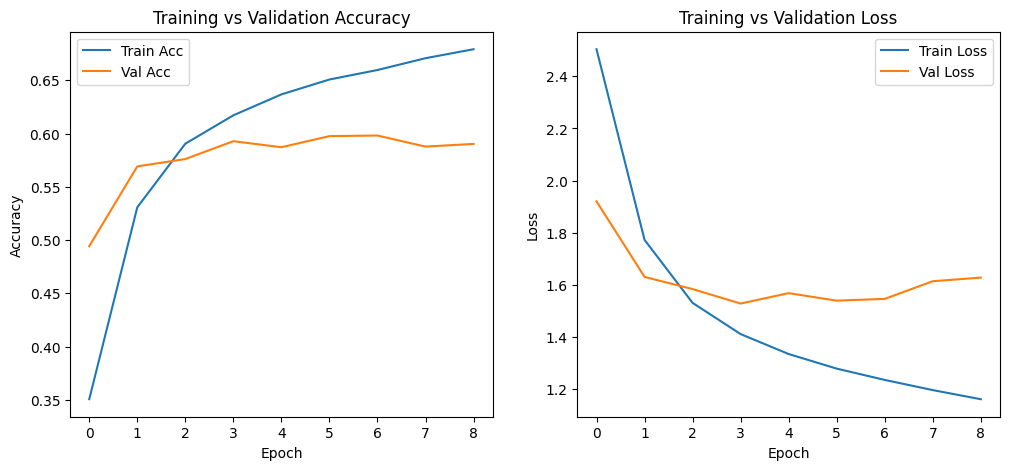

In [13]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [14]:
# Evaluate on test set
test_loss, test_acc = baseline_model.evaluate(X_test, y_test_enc)
print(f"\n Baseline Test Accuracy: {test_acc:.4f}")

from sklearn.metrics import classification_report
y_pred_probs = baseline_model.predict(X_test)
y_pred = lb.classes_[y_pred_probs.argmax(axis=1)]

macro_f1 = f1_score(y_test, y_pred, average='macro')
print("Macro F1:", macro_f1)

report = classification_report(y_test, y_pred, target_names=le.classes_)
print(report)

print(classification_report(y_test, y_pred, digits=4))

940/940 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5920 - loss: 1.5311

 Baseline Test Accuracy: 0.5920
940/940 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Macro F1: 0.42302087407864725
                precision    recall  f1-score   support

ARTS & CULTURE       0.38      0.07      0.12       226
  BLACK VOICES       0.45      0.38      0.41       678
      BUSINESS       0.47      0.45      0.46       890
       COLLEGE       0.42      0.17      0.25       172
        COMEDY       0.66      0.27      0.38       774
         CRIME       0.53      0.55      0.54       510
CULTURE & ARTS       0.29      0.37      0.33       355
       DIVORCE       0.79      0.69      0.73       513
     EDUCATION       0.45      0.17      0.24       150
 ENTERTAINMENT       0.44      0.83      0.57      2408
   ENVIRONMENT       0.50      0.29      0.36       199
         FIFTY       0.37      0.06      0.11       210
  FOOD & DRINK       0.60      0.80      0.69       934
     GOOD NEWS       0.20      0.02 

/opt/anaconda3/envs/tfmetal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/tfmetal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/tfmetal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

### Graded Questions (5 pts each)

1. **Model Architecture:**
   Describe your baseline model and justify why this structure suits your dataset.

2.1. **Your answer here:**

        The baseline model architecture created has 5 layers total. The input layer takes in the tokenized headline and short_description. The embedding layer then converts the tokens into vectors with a max vocab of 20,000 and shortens them to vectors of a max length of 128. This layer is used to capture the semantic meaning of the words and relationships present. The next layer is the GlobalAveragePooling Layer which takes the average of all embeddings and produces fixed-size vectors for all the samples in order to reduce overfitting and keep the model lightweight. This layer is especially important since it makes sure that different length inputs don't break the model. The fourth layer in this baseline model is the Hidden Dense Layer which utilizes ReLU activation to map the pooled embeddings to features used for classification. The final layer is the output layer which is a dense layer that uses softmax activation and produces a set of probabilities for each category.

        This baseline model is efficient and trains very quickly. The use of pooling in this model reduces the overall risk of overfitting commonly associated with multi-class problems.

2. **Training Behavior:**
   Summarize the model’s training and validation curves. What trends did you observe?

2.2. **Your answer here:**

        The plots generated provide key insights into the effectiveness of the model. Initially, the validation accuracy is greater than the training accuracy which indicates that the model is learning. At epoch 2, the training accuracy increases above the validation accuracy and keeps a fairly high updwards trajectory. While we were expecting the training accuracy to increase, this significant increase in the gap between the curve indicates some overfitting is occuring. This is confirmed by the fact that the validation loss is increasing while the training loss continues to decrease.


  3. **Baseline Metrics:**
   Report validation and test metrics. What does this performance tell you about dataset difficulty?

2.3. **Your answer here:**

        The test accuracy is ~0.60 which indicates taht 60% of the samples will be predicted correctly by the model. The Macro-F1 score is 0.43. Since Macro-F1 is the average per-class, it is not surprising that this value is lower than the test accuracy since despite the use of stratification in pre-processing, many classes are underrepresented which results in low F1 scores for those classes.


  4. **Reflection:**
   What are the main limitations of your baseline? Which specific improvements (depth, regularization, pretraining) would you try next?
  

2.4. **Your answer here:**

        Based upon the output F1 and accuracy metrics and the plots of training behavior, it is clear this model can be significantly improved. The baseline model is too small and does not have enough layers or complexity to capture all of the patterns present in the dataset for all 37 classes. Additionally, there is still a class imbalance that affects the model's performance. This can be remedied by the implementation of class weights during model training to weight the rare classes higher and eliminate some class size bias. Additionally, the use of DistilBERT or a pretrained model could significantly improve the model accuracy and F1 metric outputs.


## Problem 3 – Custom (Original) Model (20 pts)(Peter)

### Goal

Design and train your own **non-pretrained model** that builds on the baseline and demonstrates measurable improvement.
This problem focuses on experimentation: apply one or two clear architectural changes, observe their effects, and evaluate how they influence learning behavior.


### Steps to Follow

1. **Modify or extend your baseline architecture**

   * Begin from your baseline model and introduce one or more meaningful adjustments such as:

     * Adding **dropout** or **batch normalization** for regularization.
     * Increasing **depth** (extra convolutional or dense layers).
     * Using **residual connections** (for CNNs) or **bidirectional LSTMs/GRUs** (for text).
     * Trying alternative activations like `ReLU`, `LeakyReLU`, or `GELU`.
   * Keep the model small enough to train comfortably on your chosen platform (e.g., Colab)

2. **Observe what specific limitations you want to address**

   * Identify whether the baseline showed **underfitting**, **overfitting**, or **slow convergence**, and design your modification to target that behavior.
   * Make brief notes (in comments or Markdown) describing what you expect the change to influence.

3. **Train and evaluate under the same conditions**

   * Use the **same data splits**, **random seed**, and **metrics** as in Problem 2.
   * Apply **early stopping** on validation loss.
   * Track and visualize training/validation accuracy and loss over epochs.

4. **Compare outcomes to the baseline**

   * Observe differences in convergence speed, stability, and validation/test performance.
   * Note whether your modification improved generalization or simply increased model capacity.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Sequential
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.layers import LayerNormalization, MaxPooling2D,Dropout,GlobalAveragePooling2D,Dense
from tensorflow.keras.layers import Conv2D,BatchNormalization,Activation,GlobalMaxPooling1D, Flatten

# 3.1 enhance baseline architecture


baseline_model = Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    layers.TextVectorizationvectorizer(inputs),
    layers.Embedding(input_dim=max_vocab, output_dim=embedding_dim),
    layers.GlobalAveragePooling1D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

baseline_model.summary()

ValueError: Only instances of `keras.Layer` can be added to a Sequential model. Received: <KerasTensor shape=(None, 128), dtype=int64, sparse=False, ragged=False, name=keras_tensor_15> (of type <class 'keras.src.backend.common.keras_tensor.KerasTensor'>)

### Graded Questions (5 pts each)

1. **Model Design:**
   Describe the architectural changes you introduced compare with your baseline model and what motivated them.

3.1. **Your answer here:**



2. **Training Results:**
   Present key validation and test metrics. Did your modifications improve performance?

3.2. **Your answer here:**



3. **Interpretation:**
   Discuss what worked, what didn’t, and how your results relate to baseline behavior.

3.3. **Your answer here:**



4. **Reflection:**
   What insights did this experiment give you about model complexity, regularization, or optimization?

3.4. **Your answer here:**



## Problem 4 – Pretrained Model (Transfer Learning) (20 pts) (August)

### Goal

Apply **transfer learning** to see how pretrained knowledge improves accuracy, convergence speed, and generalization.
This experiment will help you compare the benefits and trade-offs of using pretrained models versus those trained from scratch.


### Steps to Follow

1. **Select a pretrained architecture**

   * **Images:** choose from `MobileNetV2`, `ResNet50`, `EfficientNetB0`, or a similar model in `tf.keras.applications`.
   * **Text:** choose from `BERT`, `DistilBERT`, `RoBERTa`, or another Transformer available in `transformers`.

2. **Adapt the model for your dataset**

   * Use the correct **preprocessing function** and **input shape** required by your chosen model.
   * Replace the top layer with your own **classification head** (e.g., `Dense(num_classes, activation='softmax')`).

3. **Apply transfer learning**

   * Choose an appropriate **training strategy** for your pretrained model. Options include:

     * **Freezing** the pretrained base and training only a new classification head.
     * **Partially fine-tuning** selected upper layers of the base model.
     * **Full fine-tuning** (all layers trainable) with a reduced learning rate.
   * Adjust your learning rate schedule to match your strategy (e.g., smaller LR for fine-tuning).
   * Observe how your chosen approach affects **validation loss**, **training time**, and **model stability**.

4. **Train and evaluate under consistent conditions**

   * Use the same **splits**, **metrics**, and **evaluation protocol** as in earlier problems.
   * Record training duration, validation/test performance, and any resource constraints (GPU memory, runtime).

5. **Compare and analyze**

   * Observe how transfer learning changes both **performance** and **efficiency** relative to your baseline and custom models.
   * Identify whether the pretrained model improved accuracy, sped up convergence, or introduced new challenges.


### Graded Questions (5 pts each)

1. **Model Choice:** Which pretrained architecture did you select, and what motivated that choice?

4.1. **Your answer here:**



2. **Fine-Tuning Plan:** Describe your fine-tuning strategy and why you chose it. 

4.2. **Your answer here:**



3. **Performance:** Report key metrics and compare them with your baseline and custom models.

4.3. **Your answer here:**



4. **Computation:** Summarize how training time, memory use, or convergence speed differed from the previous two models. 

4.4. **Your answer here:**



## Problem 5 – Comparative Evaluation and Discussion (20 pts)

### Goal

Compare your **baseline**, **custom**, and **pretrained** models to evaluate how design choices affected performance, efficiency, and generalization.
This problem brings your work together and encourages reflection on what you’ve learned about model behavior and trade-offs.

**Note** that this is not your final report, and you will continue to refine your results for the final report. 

### Steps to Follow

1. **Compile key results**

   * Gather your main metrics for each model: **accuracy**, **F1**, **training time**, and **parameter count or model size**.
   * Ensure all numbers come from the same evaluation protocol and test set.

2. **Visualize the comparison**

   * Present results in a **single, well-organized chart or table**.
   * Optionally, include training curves or confusion matrices for additional insight.

3. **Analyze comparative performance**

   * Observe which model performed best by your chosen metric(s).
   * Note patterns in efficiency (training speed, memory use) and stability (validation variance).

4. **Inspect model behavior**

   * Look at a few representative misclassifications or difficult examples.
   * Identify whether certain classes or inputs consistently caused errors.

5. **Plan forward improvements**

   * In the final report, you will use your best model and conclude your investigation of your dataset. Based on your observations, decide on a model and next steps for refining your approach in the final project (e.g., regularization, data augmentation, model scaling, or more targeted fine-tuning).

### Graded Questions (4 pts each)

1. **Summary Table and Performance Analysis:** Present a clear quantitative comparison of all three models. Which model achieved the best overall results, and what factors contributed to its success?

5.1. **Your answer here:**



2. **Trade-Offs:** Discuss how complexity, accuracy, and efficiency balanced across your models.

5.2. **Your answer here:**



3. **Error Patterns:** Describe the types of examples or classes that remained challenging for all models.

5.3. **Your answer here:**



4. **Next Steps:** Based on these findings, decide on a model to go forward with and outline your plan for improving that model. 


5.4 **Your answer here:**



### Final Question: Describe what use you made of generative AI tools in preparing this Milestone. 

**AI Question: Your answer here:**